Let's compare our method with spectral clustering for more examples.
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [8]:
import random
import math
import itertools
import numpy as np
from sklearn.cluster import spectral_clustering, SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture

import warnings
warnings.filterwarnings('ignore')

n_samples = 6000

def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)

def get_B_and_weight_vec_ring(points, threshhold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshhold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return A, B, weight_vec


def run_more_plots(points, true_labels, K, alpha, lambda_nLasso, threshhold, n_clusters, M=0.2, plot=False, is_print=True):
    A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=threshhold)

    print("computed lambda:", n_clusters**3 / (np.sum(weight_vec))**(1/n_clusters))
    E, N = B.shape

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]
    lambda_weight = lambda_nLasso * weight_vec

    our_labels = np.full(N, n_clusters-1)
    our_time = datetime.datetime.now() - datetime.datetime.now()
    for clust_num in range(n_clusters-1):

        samplingset = random.choices(np.where(true_labels==clust_num)[0], k=int(M * len(np.where(true_labels==clust_num)[0])))
        seednodesindicator = np.zeros(N)
        seednodesindicator[samplingset] = 1
        noseednodeindicator = np.ones(N)
        noseednodeindicator[samplingset] = 0


        hatx = np.zeros(N)
        newx = np.zeros(N)
        prevx = np.zeros(N)
        haty = np.array([x / (E - 1) for x in range(0, E)])
        gamma_plus = 1 + Gamma_vec[samplingset]
        start = datetime.datetime.now()
        for iterk in range(K):
            tildex = 2 * hatx - prevx
            newy = haty + Sigma * B.dot(tildex)  # chould be negative
            res = abs(newy) / lambda_weight
            res[res < 1] = 1
            haty = newy / res

            newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

            newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

            newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
            prevx = np.copy(hatx)
            hatx = newx  # could be negative
        our_time += datetime.datetime.now() - start
        X = newx
        X = np.nan_to_num(X, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(len(X), 1))
        matched_label = kmeans.labels_[samplingset][0]
        our_labels[np.where(kmeans.labels_ == matched_label)[0]] = clust_num

    our_accuracy = accuracy(our_labels, true_labels)
    our_nmi = normalized_mutual_info_score(our_labels, true_labels)
    if is_print:
        print ('our time is:', our_time)
        print ('our accuracy is:', our_accuracy)
        print ('our nmi is:', our_nmi)
    
    if plot:
        print('our method clusters')
        for label_name in list(set(our_labels)):
            plt.scatter(points[np.where(our_labels == label_name)[0]][:, 0], points[np.where(our_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
    
    start = datetime.datetime.now()
    labels = spectral_clustering(A, n_clusters=n_clusters)
    spectral_time = datetime.datetime.now() - start
    spectral_accuracy = accuracy(labels, true_labels)
    spectral_nmi = normalized_mutual_info_score(labels, true_labels)
    if is_print:
        print ('spectral clustering time is:', spectral_time)
        print ('spectral clustering accuracy is:', spectral_accuracy)
        print ('spectral clustering nmi is:', spectral_nmi)

    
    if plot:
        print('spectral clustering clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(labels == label_name)[0]][:, 0], points[np.where(labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    
        print('true clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(true_labels == label_name)[0]][:, 0], points[np.where(true_labels == label_name)[0]][:, 1], label='0')

        plt.show()
        plt.close()
    return our_accuracy, our_nmi, our_time, spectral_accuracy, spectral_nmi, spectral_time

     
def run_more_plots_all_together(points, true_labels, K, alpha, lambda_nLasso, threshhold, n_clusters, tmp=0, M=0.2, plot=False, is_print=True):
    A, B, weight_vec = get_B_and_weight_vec_ring(points, threshhold=threshhold)
    
    print("computed lambda:", 5 / math.sqrt(np.sum(weight_vec)))

    E, N = B.shape

    samplingset = random.choices(np.where(true_labels==tmp)[0], k=int(M * len(np.where(true_labels==tmp)[0])))
#     samplingset = random.choices(true_labels, k=int(M * len(true_labels)))
    seednodesindicator = np.zeros(N)
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0

    Gamma_vec = np.array(1. / (np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    fac_alpha = 1. / (Gamma_vec * alpha + 1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x / (E - 1) for x in range(0, E)])
    lambda_weight = lambda_nLasso * weight_vec
    gamma_plus = 1 + Gamma_vec[samplingset]
    start = datetime.datetime.now()
    for iterk in range(K):
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        res = abs(newy) / lambda_weight
        res[res < 1] = 1
        haty = newy / res

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative

        newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / gamma_plus

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
    our_time = datetime.datetime.now() - start
    X = newx
    X = np.nan_to_num(X, 0)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X.reshape(len(X), 1))
    our_accuracy = accuracy(kmeans.labels_, true_labels)
    if is_print:
        print('our time is:', our_time)
        print ('our accuracy is:', our_accuracy)
    
    if plot:
        print('our method clusters')
        for label_name in list(set(kmeans.labels_)):
            plt.scatter(points[np.where(kmeans.labels_ == label_name)[0]][:, 0], points[np.where(kmeans.labels_ == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()
    

    start = datetime.datetime.now()
    labels = spectral_clustering(A, n_clusters=n_clusters)
    spectral_time = datetime.datetime.now() - start
    spectral_accuracy = accuracy(labels, true_labels)
    if is_print:
        print ('spectral clustering time is:', spectral_time)
        print ('spectral clustering accuracy is:', spectral_accuracy)

    if plot:
        print('spectral clustering clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(labels == label_name)[0]][:, 0], points[np.where(labels == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()
    
    if plot:
        print('true clusters')
        for label_name in list(set(labels)):
            plt.scatter(points[np.where(true_labels == label_name)[0]][:, 0], points[np.where(true_labels == label_name)[0]][:, 1], label='0')
    
        plt.show()
        plt.close()

    return our_accuracy, our_time, spectral_accuracy, spectral_time


In [9]:
def run_noisy_circles(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.3, noise=.05) 

    points = noisy_circles[0] * 2
    true_labels = noisy_circles[1]

    return run_more_plots(points, true_labels, 20, alpha, lambda_lasso, 0.2, 2, plot=plot, is_print=is_print)
 

accuracy for the automatic tuned lambda
sample: 0
computed lambda: 0.004617720688063447
our time is: 0:00:02.954715
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


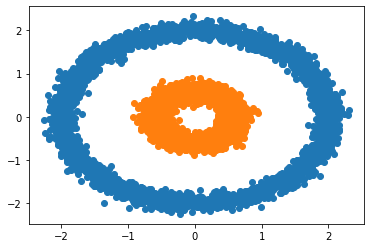

spectral clustering time is: 0:00:05.874978
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


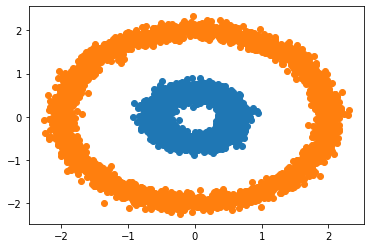

true clusters


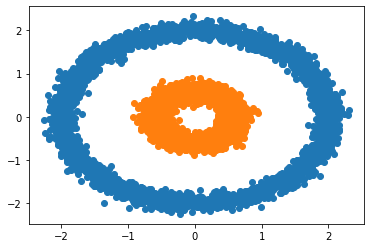

------------------------------

accuracy for the manual tuned lambda
computed lambda: 0.00462407874367486
our time is: 0:00:03.421962
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


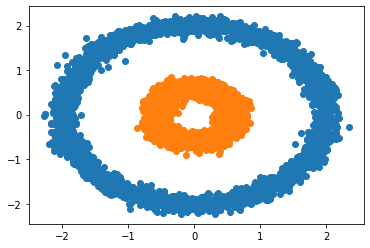

spectral clustering time is: 0:00:05.601981
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


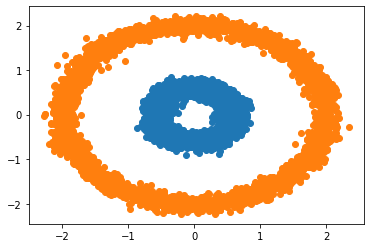

true clusters


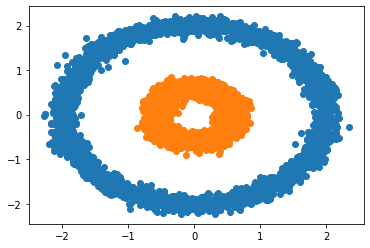

(1.0,
 1.0,
 datetime.timedelta(seconds=3, microseconds=421962),
 1.0,
 1.0,
 datetime.timedelta(seconds=5, microseconds=601981))

In [10]:
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_noisy_circles(0.1, 0.0046, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_noisy_circles(0.1, 0.005, True)   

In [11]:
def run_noisy_moons(alpha, lambda_lasso, plot=False, is_print=True):
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

    points = noisy_moons[0] * 3
    true_labels = noisy_moons[1]
    

    return run_more_plots(points, true_labels, 25, alpha, lambda_lasso, 0.2, 2, plot=plot, is_print=is_print)
   

accuracy for the automatic tuned lambda
sample: 0
computed lambda: 0.006718383694588819
our time is: 0:00:01.603274
our accuracy is: 0.9998333333333334
our nmi is: 0.9978344262799547
our method clusters


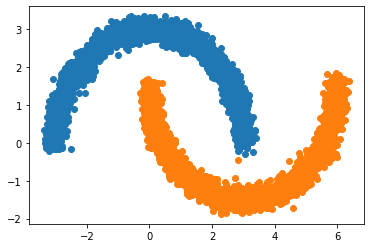

spectral clustering time is: 0:00:06.812795
spectral clustering accuracy is: 0.9998333333333334
spectral clustering nmi is: 0.9978344262799547
spectral clustering clusters


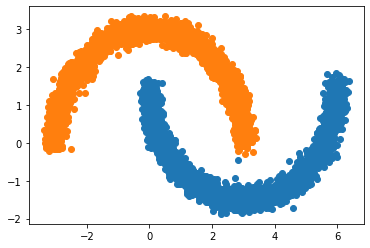

true clusters


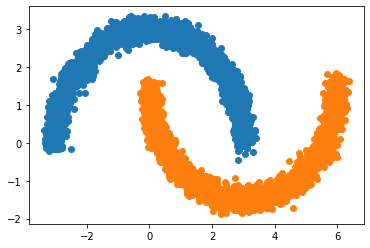

------------------------------

accuracy for the manual tuned lambda
computed lambda: 0.006708516639910749
our time is: 0:00:01.721331
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


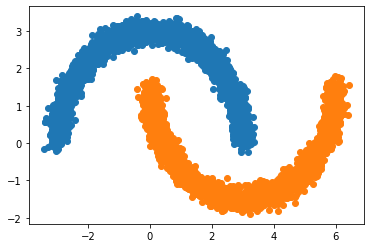

spectral clustering time is: 0:00:08.920411
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


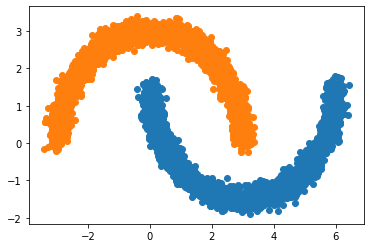

true clusters


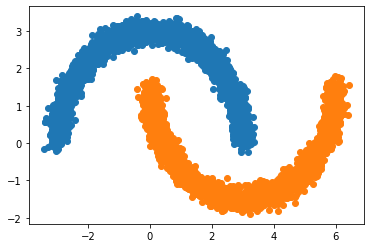

(1.0,
 1.0,
 datetime.timedelta(seconds=1, microseconds=721331),
 1.0,
 1.0,
 datetime.timedelta(seconds=8, microseconds=920411))

In [12]:
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_noisy_moons(0.1, 0.0067, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_noisy_moons(0.1, 0.005, True) 

In [13]:
def run_blobs(alpha, lambda_lasso, plot=False, is_print=True):
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

    points = blobs[0] 
    true_labels = blobs[1]

#     return run_more_plots(points, true_labels, 20, 1.0, 0.3, 0.009, 3, plot=plot, is_print=is_print)
    return run_more_plots(points, true_labels, 20, alpha, lambda_lasso, 0.009, 3, plot=plot, is_print=is_print)
    

accuracy for the automatic tuned lambda
sample: 0
computed lambda: 0.2558399130542091
our time is: 0:00:04.349181
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


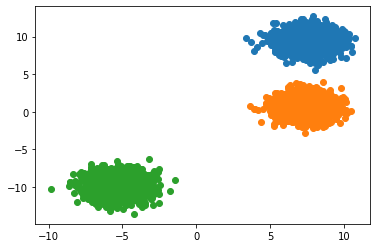

spectral clustering time is: 0:00:04.662278
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


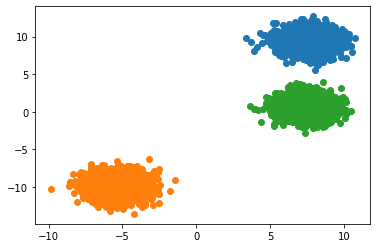

true clusters


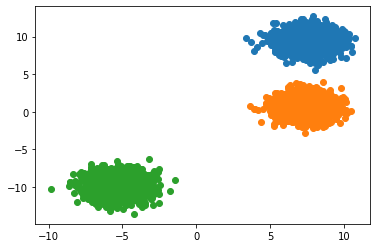

------------------------------

accuracy for the manual tuned lambda
computed lambda: 0.2558399130542091
our time is: 0:00:04.432155
our accuracy is: 1.0
our nmi is: 1.0
our method clusters


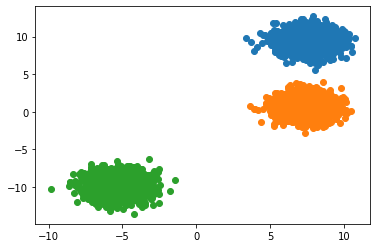

spectral clustering time is: 0:00:05.110517
spectral clustering accuracy is: 1.0
spectral clustering nmi is: 1.0
spectral clustering clusters


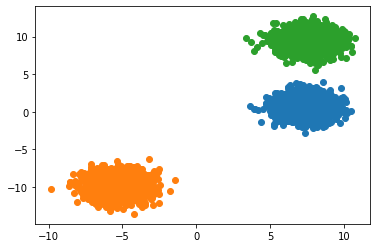

true clusters


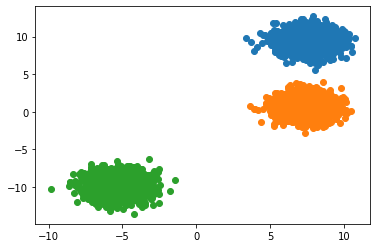

(1.0,
 1.0,
 datetime.timedelta(seconds=4, microseconds=432155),
 1.0,
 1.0,
 datetime.timedelta(seconds=5, microseconds=110517))

In [14]:
# 1.5, 0.5
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_blobs(0.1, 0.255, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_blobs(0.1, 0.5, True) 

In [15]:
def run_varied(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    varied = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)

    points = varied[0] 
    true_labels = varied[1]

#     return run_more_plots_all_together(points, true_labels, 60, alpha, lambda_lasso, 0.02, 3, plot=plot, is_print=is_print)
    return run_more_plots(points, true_labels, 60, alpha, lambda_lasso, 0.5, 3, plot=plot, is_print=is_print)

accuracy for the automatic tuned lambda
sample: 0
computed lambda: 0.26615892007762076
our time is: 0:00:04.522813
our accuracy is: 0.97
our nmi is: 0.8875475748107173
our method clusters


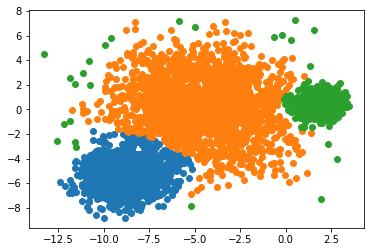

spectral clustering time is: 0:00:12.392428
spectral clustering accuracy is: 0.3338333333333333
spectral clustering nmi is: 0.0016569191291732678
spectral clustering clusters


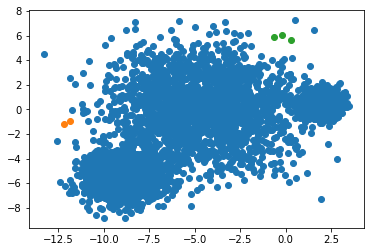

true clusters


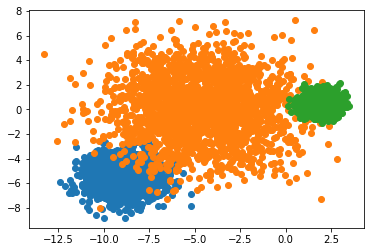

------------------------------

accuracy for the manual tuned lambda
computed lambda: 0.26615892007762076
our time is: 0:00:04.139002
our accuracy is: 0.9703333333333334
our nmi is: 0.888620471080808
our method clusters


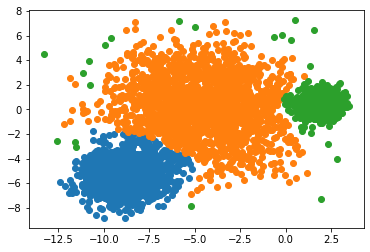

spectral clustering time is: 0:00:13.737466
spectral clustering accuracy is: 0.33366666666666667
spectral clustering nmi is: 0.0013268915636848115
spectral clustering clusters


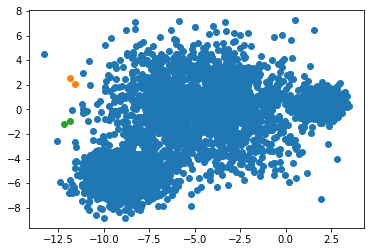

true clusters


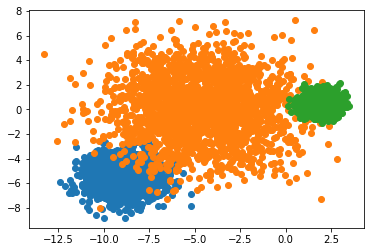

(0.9703333333333334,
 0.888620471080808,
 datetime.timedelta(seconds=4, microseconds=139002),
 0.33366666666666667,
 0.0013268915636848115,
 datetime.timedelta(seconds=13, microseconds=737466))

In [16]:
# 0.5, 0.5
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_varied(0.5, 0.266, True)
    print('------------------------------')

print()
print("accuracy for the manual tuned lambda")
run_varied(0.5, 0.3, True)

In [17]:
def run_aniso(alpha, lambda_lasso, plot=False, is_print=True):
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    points = aniso[0] 
    true_labels = aniso[1]

    return run_more_plots(points, true_labels, 50, alpha, lambda_lasso, 0.7, 3, plot=plot, is_print=is_print)

    # 1.0, 0.1
#     return run_more_plots_all_together(points, true_labels, 90, alpha, lambda_lasso, 0.4, 3, 1, plot=plot, is_print=is_print)


accuracy for the automatic tuned lambda
sample: 0
computed lambda: 0.25093318995781033
our time is: 0:00:03.483561
our accuracy is: 0.9971666666666666
our nmi is: 0.9821657158157394
our method clusters


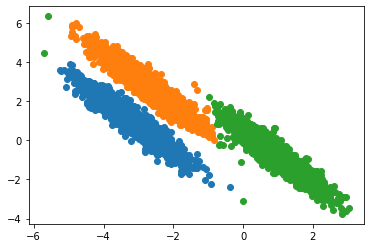

spectral clustering time is: 0:00:05.630877
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025113
spectral clustering clusters


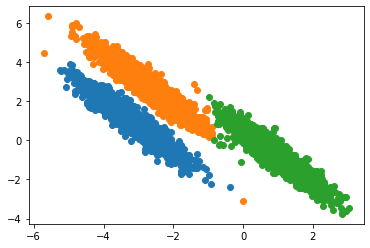

true clusters


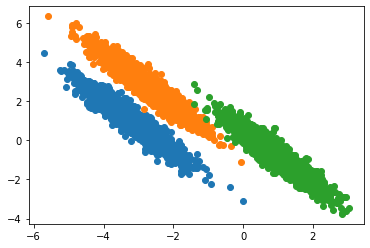

------------------------------

accuracy for the manual tuned lambda
computed lambda: 0.25093318995781033
our time is: 0:00:03.462760
our accuracy is: 0.9971666666666666
our nmi is: 0.9821657158157394
our method clusters


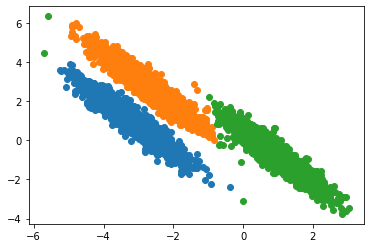

spectral clustering time is: 0:00:05.746733
spectral clustering accuracy is: 0.9971666666666666
spectral clustering nmi is: 0.9821657930025115
spectral clustering clusters


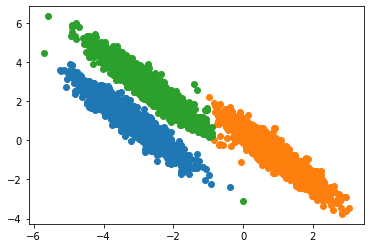

true clusters


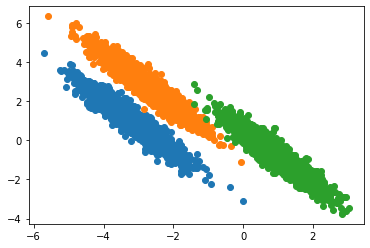

(0.9971666666666666,
 0.9821657158157394,
 datetime.timedelta(seconds=3, microseconds=462760),
 0.9971666666666666,
 0.9821657930025115,
 datetime.timedelta(seconds=5, microseconds=746733))

In [18]:
print("accuracy for the automatic tuned lambda")
for i in range(1):
    print('sample:', i)
    run_aniso(1.0, 0.25, True)
    print('------------------------------')


print()
print("accuracy for the manual tuned lambda")
run_aniso(1.0, 0.5, True) 